In [1]:
import keras 
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from PIL import Image
from imutils import paths
from os import path
from keras.optimizers import Adam,RMSprop
import pandas as pd
keras.__version__
IMAGE_DIMS = (375,250,3)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

In [3]:
date_arr = np.load('./new_date_arr.npy',allow_pickle=True)
dust_arr = np.load('./ultra_PM_avg_1.npy',allow_pickle=True)
wind_arr = np.load('./wind_arr.npy',allow_pickle=True)
humi_arr = np.load('./humi_arr.npy',allow_pickle=True)

In [4]:
import time

start = time.time() 
imagePaths = sorted(list(paths.list_images('./dataset/image')))
image_arr = []

for i in imagePaths:
    img_name = int(path.splitext(path.basename(i))[0])
    
    if img_name in date_arr :
        image = Image.open(i)
        image_crop = image.crop([380,0,600,200])
        image_crop = image_crop.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = np.concatenate((image_crop,image),axis=2)
        image = img_to_array(image)
        image_arr.append(image)
#         image = Image.open(i)
#         image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
#         image = img_to_array(image)
#         image_arr.append(image)
        
image_arr = np.array(image_arr, dtype="float") / 255.0        
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), image_arr.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 18126 images (49025.39MB)


In [5]:
from sklearn.utils import shuffle



con_data_img = image_arr
con_data_val = dust_arr

print(wind_arr.shape)
con_data_wea = np.concatenate([wind_arr.reshape(len(wind_arr),1),humi_arr.reshape(len(humi_arr),1)], axis=1)


# 국내는 PM2.5이 16이상이면 보통
# for i in range(0,dustvalue.shape[0]):
#     if int(dustvalue[i]) > 0 :
#         con_data_img.append(data[i])
#         con_data_val.append(dustvalue[i])
#         con_data_wea.append(add_info[i])
        
con_data_img, con_data_val, con_data_wea = shuffle(np.array(con_data_img), np.array(con_data_val), np.array(con_data_wea), random_state=0)
con_data_img = np.array(con_data_img)
con_data_val = np.array(con_data_val)
con_data_wea = np.array(con_data_wea)

num = int(con_data_img.shape[0]*0.85)

train_img = con_data_img[:num]
train_val = con_data_val[:num]
train_wea = con_data_wea[:num]

test_img = con_data_img[num:]
test_val = con_data_val[num:]
test_wea = con_data_wea[num:]

print(con_data_img.shape)
print(train_img.shape)
print(test_img.shape)

print(con_data_img.shape)
print(con_data_val.shape)
print(con_data_wea.shape)


(11156,)
(11156, 250, 375, 6)
(9482, 250, 375, 6)
(1674, 250, 375, 6)
(11156, 250, 375, 6)
(11156,)
(11156, 2)


In [6]:
# import the necessary packages
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, GRU, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

chanDim=-1
model = Sequential()

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],6)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


image_input = Input(shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],6))
encoded_image = model(image_input)

# 다음은 문제를 벡터로 인코딩할 숫자 모델을 정의합니다
numeric_input = Input(shape=(2,))
embedded_numeric = Embedding(input_dim=100, output_dim=128, input_length=2)(numeric_input)

# numeric_input2 = Dense(256, activation="linear")(embedded_numeric)
# print(embedded_numeric.shape)

#numeric_input2 = GRU(256)(embedded_numeric)
numeric_input2 = LSTM(128)(embedded_numeric)
# print(numeric_input2.shape)


# numeric_input = Input(shape=(8,), dtype='float32')
# numeric_input1 = Dense(1000,activation='linear')(numeric_input)
# numeric_input2 = Dense(100,activation='linear')(numeric_input1)

# 질문 벡터와 이미지 벡터를 연결해 봅시다:
merged = keras.layers.concatenate([encoded_image, numeric_input2],axis=-1)

output = Dense(1)(merged)

# 그리고 상층의 로지스틱 회귀를 수치에 대해 학습시킵니다:
# output = Dense(1024, activation='softmax')(merged)
# output = Dense(128, activation='softmax')(output)
# output = Dense(1)(output)
# 다음은 최종 모델입니다:
model = Model(inputs=[image_input, numeric_input], outputs=output)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
#opt = RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
opt = Adam(lr=0.002, epsilon=None, decay=0.0)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"])
# logcosh, mes, 
H = model.fit([train_img,train_wea], train_val ,batch_size=48, epochs=50)


print("[INFO] serializing network...")
model.save('lstm-roi-ultra-PM-1.model')



Instructions for updating:
Use tf.cast instead.
Epoch 1/50
9482/9482 [==============================] - 51s 5ms/step - loss: 249.6542 - acc: 0.0554
Epoch 2/50
9482/9482 [==============================] - 41s 4ms/step - loss: 187.1624 - acc: 0.0579
Epoch 3/50
9482/9482 [==============================] - 41s 4ms/step - loss: 185.2391 - acc: 0.0566
Epoch 4/50
9482/9482 [==============================] - 41s 4ms/step - loss: 180.4659 - acc: 0.0571
Epoch 5/50
9482/9482 [==============================] - 41s 4ms/step - loss: 170.2226 - acc: 0.0610
Epoch 6/50
9482/9482 [==============================] - 41s 4ms/step - loss: 160.1537 - acc: 0.0695
Epoch 7/50
9482/9482 [==============================] - 41s 4ms/step - loss: 150.3275 - acc: 0.0723
Epoch 8/50
9482/9482 [==============================] - 41s 4ms/step - loss: 152.0249 - acc: 0.0658
Epoch 9/50
9482/9482 [==============================] - 41s 4ms/step - loss: 147.4202 - acc: 0.0697
Epoch 10/50
9482/9482 [=============================

In [8]:
print(image_arr.shape)
print(dust_arr.shape)

print(wind_arr.shape)
print(humi_arr.shape)

print(test_img.shape)
print(test_wea.shape)

print(model.predict([test_img, test_wea]))

y_pred = np.squeeze(np.round(model.predict([test_img, test_wea]).astype(np.int64)))

print(test_val.shape)
print(y_pred.shape)

(11156, 250, 375, 6)
(11156,)
(11156,)
(11156,)
(1674, 250, 375, 6)
(1674, 2)
[[ 5.2516    ]
 [ 3.9700277 ]
 [12.885501  ]
 ...
 [ 1.1127719 ]
 [ 6.321416  ]
 [-0.44100928]]
(1674,)
(1674,)


In [9]:
# print(con_data_val.shape)
# print(train_val.shape)
# print(test_val.shape)
print(con_data_img.shape)
print(con_data_val.shape)
print(con_data_wea.shape)

(11156, 250, 375, 6)
(11156,)
(11156, 2)


In [10]:
RMSE = mean_squared_error(test_val.astype(np.int64), y_pred)**0.5
R2SCORE = r2_score(test_val.astype(np.int64), y_pred)

print("RMSE 는 : " , RMSE)
print("R2SCORE 는 : ", R2SCORE)

RMSE 는 :  11.028419895898004
R2SCORE 는 :  0.4247050363332888


Text(70, 50, 'R-squared = 0.42')

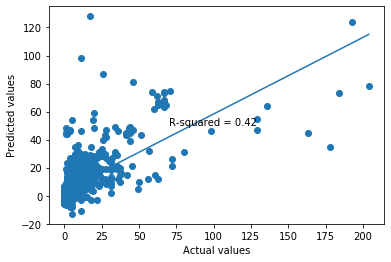

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

test_val=np.squeeze(test_val.astype(np.int64))

plt.scatter(test_val,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(test_val), np.poly1d(np.polyfit(test_val, y_pred, 1))(np.unique(test_val)))

plt.text(70, 50, 'R-squared = %0.2f' % R2SCORE)

In [12]:
np.round(test_val.astype(np.int64))
np.where(test_val >50)

(array([  13,   83,  128,  180,  188,  195,  217,  267,  349,  351,  406,
         428,  492,  686,  722,  739,  767,  875,  908,  956,  982,  989,
        1018, 1122, 1123, 1159, 1297, 1517, 1585, 1613], dtype=int64),)

예측값 :  5
실제값 :  6


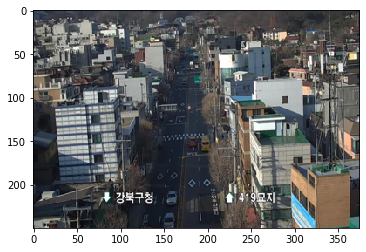

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
i=1241

plt.imshow(test_img[i][:,:,3:])
print("예측값 : ", y_pred[i])
print("실제값 : ", test_val[i])